In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from cmcrameri import cm
from scipy.interpolate import interp1d
from pqcd.utils import (
    rcparams, 
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
    )
plt.rcParams.update(rcparams)

### Default GP

In [3]:
collated_eos_path = '../data/eos-draws-default/collated_np_all_post.csv'

In [4]:
collated_eos = pd.read_csv(collated_eos_path)

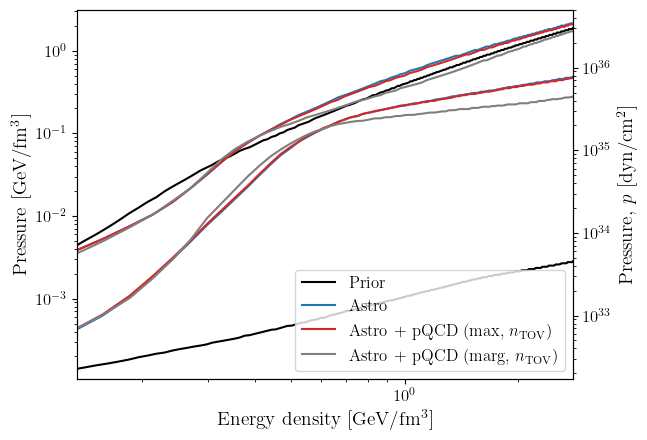

In [5]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Prior
# -----

prior_x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))
prior_quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

ax.plot(prior_x, prior_quantiles.loc[5,:].values, color='k', label='Prior')
ax.plot(prior_x, prior_quantiles.loc[95,:].values, color='k')

# Astro-only
# ----------

astro_x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))
astro_quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles.old/p_of_eps_quantiles.csv')
)

ax.plot(astro_x, astro_quantiles.loc[5,:].values, color='C0', label='Astro')
ax.plot(astro_x, astro_quantiles.loc[95,:].values, color='C0')

# Max pQCD, nTOV, Xmarg
# ---------------------

pqcd_x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))
pqcd_quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles.old/p_of_eps_quantiles_ntov_Xmarg.csv')
)

ax.plot(pqcd_x, pqcd_quantiles.loc[5,:].values, color='C3', label='Astro + pQCD (max, $n_\mathrm{TOV}$)')
ax.plot(pqcd_x, pqcd_quantiles.loc[95,:].values, color='C3')

# Marg pQCD, nTOV
# ---------------

pqcd_x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))
pqcd_quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles.old/p_of_eps_quantiles_ntov_marg.csv')
)

ax.plot(pqcd_x, pqcd_quantiles.loc[5,:].values, color='C7', label='Astro + pQCD (marg, $n_\mathrm{TOV}$)')
ax.plot(pqcd_x, pqcd_quantiles.loc[95,:].values, color='C7')

# ---

ylim_default = ax.get_ylim()

ax.legend(loc='lower right')

xlim = (0.13471795348380078, 17.002209254489188)
ylim = (0.0014798402249155988, 6.262273589369166)

ax.set_xlim(xlim[0], astro_x[-1])
ax.set_ylim(ylim[0]/14, ylim[1]/2)

twinx = ax.twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax.get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

# ax.set_title('Maximized likelihood, $n_\mathrm{term} = n_\mathrm{TOV}$, $X \in [1/2, 2]$')
ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]');

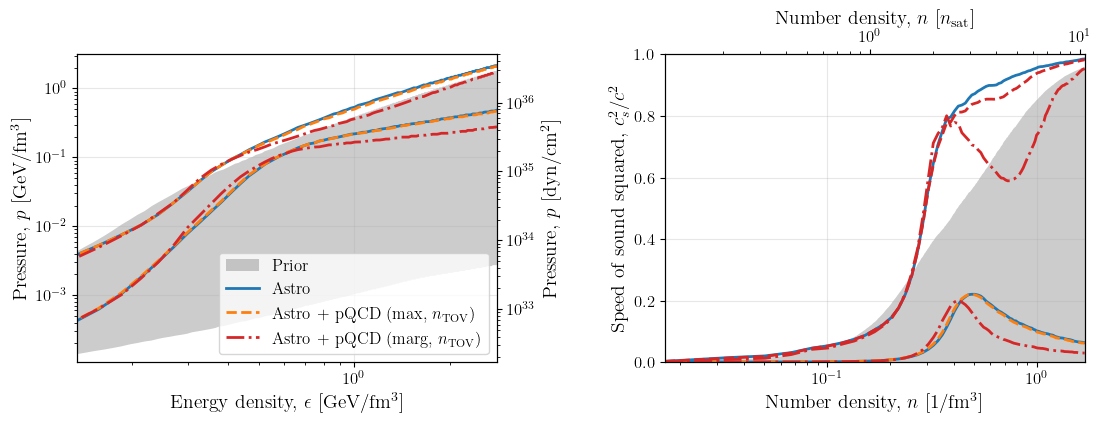

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

fig.subplots_adjust(wspace=0.4)
for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

# Prior
# -----

prior_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))
prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    prior_x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

prior_x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000))
astro_quantiles_cn = pd.read_csv(f'../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_prior.csv')

axs[1].fill_between(
    prior_x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# Astro-only
# ----------

lw = 2

astro_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))
astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles.old/p_of_eps_quantiles.csv')
)

axs[0].plot(
    astro_x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[0].plot(astro_x_pe, astro_quantiles_pe.loc[95,:].values, color='C0', lw=lw)

# ---

astro_x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 100))
astro_quantiles_cn = pd.read_csv(f'../data/eos-draws-default/quantiles.old/cs2_of_rho_quantiles.csv')

axs[1].plot(
    astro_x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[1].plot(astro_x_cn, astro_quantiles_cn.loc[95,:].values, color='C0', lw=lw)

# Max pQCD, nTOV, Xmarg
# ---------------------

pqcd_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))
pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles.old/p_of_eps_quantiles_ntov_Xmarg.csv')
)

axs[0].plot(
    pqcd_x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $n_\mathrm{TOV}$)'
)
axs[0].plot(
    pqcd_x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw
)

# ---

pqcd_x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 100))
pqcd_quantiles_cn = pd.read_csv(
    f'../data/eos-draws-default/quantiles.old/cs2_of_rho_quantiles_ntov_Xmarg.csv'
)

axs[1].plot(
    pqcd_x_cn, 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $n_\mathrm{TOV}$)'
)
axs[1].plot(
    pqcd_x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='--',
    lw=lw
)

# Marg pQCD, nTOV
# ---------------

pqcd_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))
pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles.old/p_of_eps_quantiles_ntov_marg.csv')
)

axs[0].plot(
    pqcd_x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[0].plot(
    pqcd_x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw
)

# ---

pqcd_x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 100))
pqcd_quantiles_cn = pd.read_csv(
    f'../data/eos-draws-default/quantiles.old/cs2_of_rho_quantiles_ntov_marg.csv'
)

axs[1].plot(
    pqcd_x_cn, 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[1].plot(
    pqcd_x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw
)



# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_ylim(0, 1)

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$');